In [31]:
import numpy as np
import pandas as pd 
import time
from lightgbm import LGBMClassifier, plot_importance
# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from mlflow.models import infer_signature
from sklearn import model_selection
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import shap
#from joblib import dump, load
import skops.io as sio
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier



# File system manangement
import os
import re
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

import mlflow
import mlflow.sklearn # Wrapper pour scikit-learn

sns.set_theme(style="whitegrid", palette="pastel")

In [65]:
df = pd.read_csv('final_data/final_df.csv')

In [66]:
df['TARGET'].isna().sum()

48744

In [67]:
y = df['TARGET']

In [68]:
min_count = int(0.5*df.shape[0] + 1)
df = df.dropna( axis=1, thresh=min_count)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(df.median(), inplace=True)

In [5]:
df['TARGET'] = y

In [6]:
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [7]:
#en refaire un plus tard avec probas!!
def my_score(y, y_pred):
    conf = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = conf.ravel()


    # Overall accuracy
    ACC = (tp+tn)/(tp+fp+10*fn+tn)
    return ACC

In [8]:
#en refaire un plus tard avec probas!!
def my_score_with_proba(y, y_pred_prob, tresh):
    y_res = []
    for i in y_pred_prob:
        if i < tresh:
            y_res.append(1)
        else:
            y_res.append(0)
    conf = confusion_matrix(y, y_res)
    tn, fp, fn, tp = conf.ravel()

    # Overall accuracy
    ACC = (tp+tn)/(tp+fp+10*fn+tn)
    return ACC

In [9]:
def predict_from_tresh(y_pred_prob, tresh):
    y_res = []
    for i in y_pred_prob:
        if i < tresh:
            y_res.append(1)
        else:
            y_res.append(0)
    return y_res

In [10]:
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]
print("Splitting train and test sets Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
#we chose 5 folds to begin with
num_folds = 5

# Cross validation model with stratified kfold
folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1)

# Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]


Splitting train and test sets Train shape: (307507, 565), test shape: (48744, 565)


In [11]:
test_df[feats].shape

(48744, 562)

In [12]:
testing_df_sampled = test_df[feats].sample(frac=0.5,random_state=1)
testing_df_sampled.to_csv('API/test_dataframe.csv')

In [13]:
X, y = train_df[feats], train_df['TARGET']
X_no_target, X_no_target = test_df[feats], test_df['TARGET']

In [14]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")

In [15]:
def eval_metrics(y, y_pred):
    acc = accuracy_score(y, y_pred)
    custom_score = my_score(y, y_pred)
    # later we can add some more metrics
    return acc, custom_score

In [17]:
def plot_model_roc_curve(model, roc_auc):
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    fig = plt.gcf()
    #plt.show()
    return fig

In [18]:
def plot_model_confusion_matrix(model):
    y_pred = model.predict(X_test)
    conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
    #
    # Print the confusion matrix using Matplotlib
    #
    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    fig = plt.gcf()
    return fig

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.33, random_state=1)

In [20]:
X_train_sampled=X_train.sample(frac=0.6,random_state=1)
y_train_sampled= y_train[X_train_sampled.index]

In [21]:
print(y_train_sampled.shape)

(123617,)


We still have 123617 values to train, which seems enough

Registered model 'dummyclassifier' already exists. Creating a new version of this model...
2023/10/05 14:15:54 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: dummyclassifier, version 16
Created version '16' of model 'dummyclassifier'.


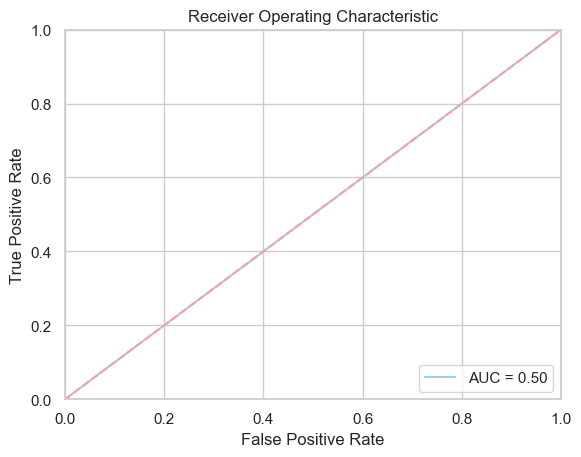

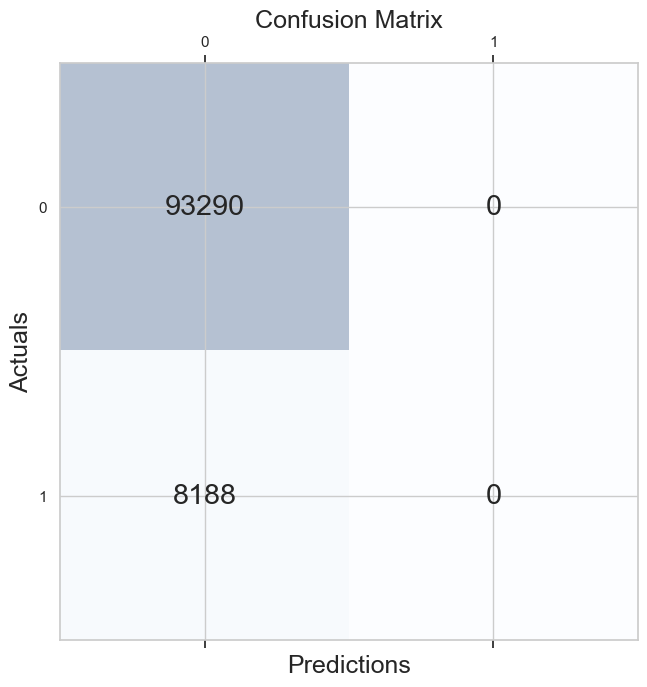

In [21]:
with mlflow.start_run(experiment_id=835998010215156356):
    
    dummy_clf = DummyClassifier(strategy="most_frequent")
    start_time = time.time()
    dummy_clf.fit(X_train_sampled, y_train_sampled)
    end_time = time.time()
    predicted = dummy_clf.predict(X_test)
    execution_time = end_time - start_time
    (acc, custom_score) = eval_metrics(y_test, predicted)
    probs = dummy_clf.predict_proba(X_test)
    preds = probs[:,1]
    roc_auc = roc_auc_score(y_test, preds)
    mlflow.log_metric("acc", acc)
    mlflow.log_metric("custom_score", custom_score)
    mlflow.log_metric("auc", roc_auc)
    mlflow.log_metric("execution_time", execution_time)
    roc_curve_model = plot_model_roc_curve(dummy_clf, roc_auc)
    mlflow.log_figure(roc_curve_model, "roc_curve.png")
    
    my_conf_mat = plot_model_confusion_matrix(dummy_clf)
    mlflow.log_figure(my_conf_mat, "confusion_matrix.png")

    signature = infer_signature(X_test, predicted)
    mlflow.sklearn.log_model(
        dummy_clf, "model", registered_model_name="dummyclassifier", signature=signature
    )

Now that we did our dummyclassifier let's make a first model of logisticRegression, using AUC as score to compare the results

/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/maxence/

acc 0.8129545320167918
execution_time 226.7501790523529
custom_score 0.516956799639057
auc 0.602771106094359


Registered model 'logistic_reg' already exists. Creating a new version of this model...
2023/10/05 14:20:03 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: logistic_reg, version 10
Created version '10' of model 'logistic_reg'.


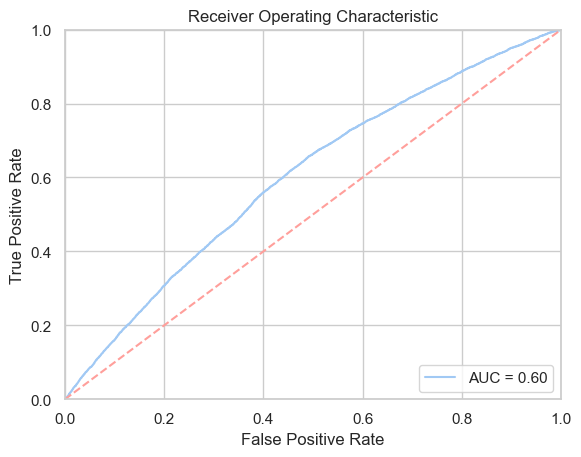

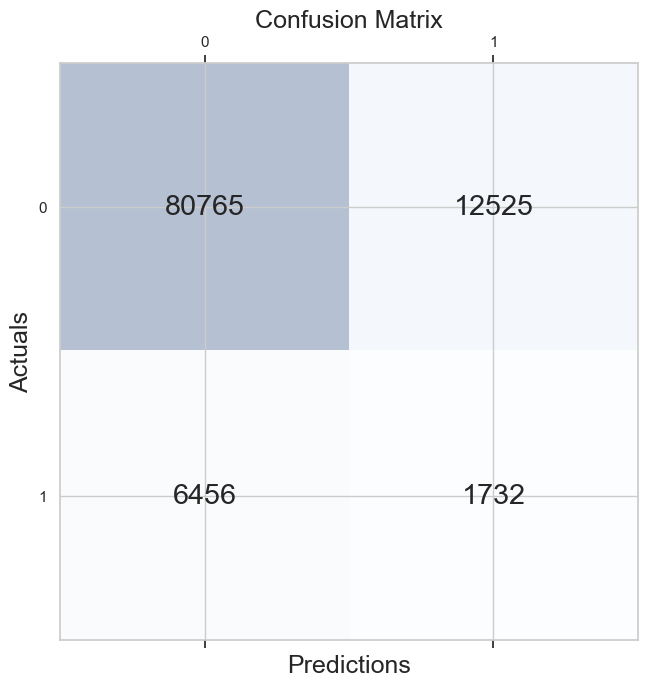

In [22]:
with mlflow.start_run(experiment_id=835998010215156356):
    
    hyperparameters = {
        #'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
        'penalty': [None, 'l2'],
        'C': [ 0.1, 1, 10]
    }
    # Define logistic regression model
    logistic_reg = LogisticRegression(random_state=1, class_weight='balanced', max_iter=500)
    # Define GridSearchCV object
    start_time = time.time()
    
    grid_search = model_selection.RandomizedSearchCV(
            logistic_reg,
            hyperparameters,
            cv=5,
            n_iter = 20,
            scoring='roc_auc',
            n_jobs = -1,
            verbose=0)

    # Fit model
    best_clf = grid_search.fit(X_train_sampled, y_train_sampled)
    end_time = time.time()
    execution_time = end_time - start_time

    logistic_reg = LogisticRegression(**best_clf.best_params_,
                   random_state=1,
                   class_weight='balanced', )

    #we used a sampled version to be faster in the gridsearch, but let's use all the train set in the final fit
    logistic_reg.fit(X_train,y_train)
    predicted = logistic_reg.predict(X_test)
    (acc, custom_score) = eval_metrics(y_test, predicted)
    probs = logistic_reg.predict_proba(X_test)
    preds = probs[:,1]
    roc_auc = roc_auc_score(y_test, preds)
    mlflow.log_metric("acc", acc)
    mlflow.log_metric("execution_time", execution_time)
    mlflow.log_metric("custom_score", custom_score)
    mlflow.log_metric("auc", roc_auc)
    print("acc", acc)
    print("execution_time", execution_time)
    print("custom_score", custom_score)
    print("auc", roc_auc)
    roc_curve_model = plot_model_roc_curve(logistic_reg, roc_auc)
    mlflow.log_figure(roc_curve_model, "roc_curve.png")
    mlflow.log_params(logistic_reg.get_params())
    my_conf_mat = plot_model_confusion_matrix(logistic_reg)
    mlflow.log_figure(my_conf_mat, "confusion_matrix.png")

    signature = infer_signature(X_test, predicted)
    mlflow.sklearn.log_model(
        logistic_reg, "model", registered_model_name="logistic_reg", signature=signature
    )

We can see here that the roc_auc is slightly better, but we have a lot of false positive, that we don't want.

Let's create a method to see if our results inside each folds are close to each other

In [22]:
def resultize(clf):
    res = clf.cv_results_
    res = pd.DataFrame(res)
    #cols = [i for i in res.columns if "split" not in i]
    cols = res.columns
    res = res[cols]
    res = res.sort_values("rank_test_score")
    return res

We can only look at the best result

In [24]:
display(resultize(grid_search).loc[resultize(grid_search)['rank_test_score']==1])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_penalty,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,61.266145,29.743585,0.620357,0.151455,l2,1,"{'penalty': 'l2', 'C': 1}",0.621932,0.620376,0.578242,0.6071,0.605589,0.606648,0.015686,1


Each fold seems to have a pretty similar result

Now we can Try to do the same thing, but this time using our custom scorer, to see if the results are different:

/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/maxence/

acc 0.8161670509864207
execution_time 226.4329240322113
custom_score 0.518035514357733
auc 0.6040675176340247


Registered model 'logistic_reg' already exists. Creating a new version of this model...
2023/10/05 14:24:10 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: logistic_reg, version 11
Created version '11' of model 'logistic_reg'.


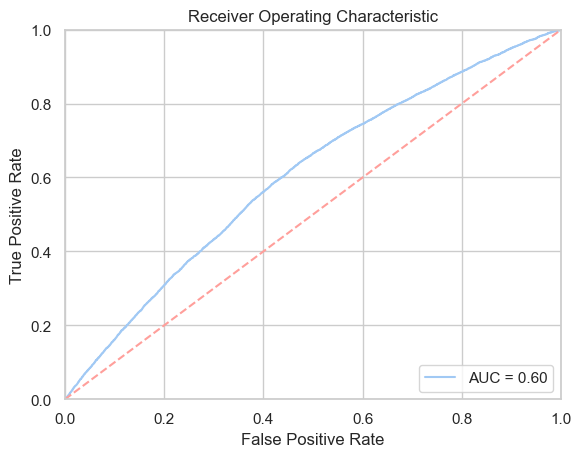

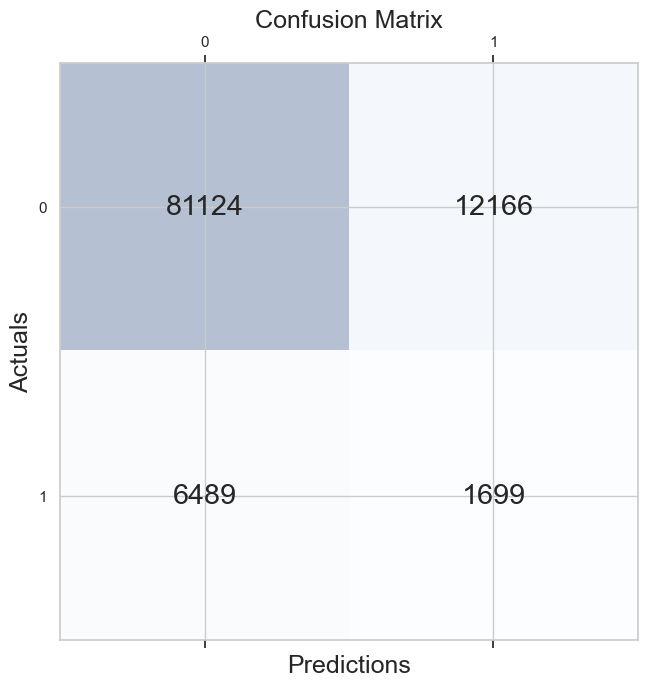

In [25]:
with mlflow.start_run(experiment_id=835998010215156356):
    
    hyperparameters = {
        #'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
        'penalty': [None, 'l2'],
        'C': [ 0.1, 1, 10]
    }
    # Define logistic regression model
    logistic_reg = LogisticRegression(random_state=1, class_weight='balanced', max_iter=500)
    #creation of the custom scorer from the function
    custom_scorer = make_scorer(my_score)  
    # Define GridSearchCV object
    start_time = time.time()
    
    grid_search = model_selection.RandomizedSearchCV(
            logistic_reg,
            hyperparameters,
            cv=5,
            n_iter = 20,
            scoring=custom_scorer,#here we use our custom scorer as our scoring function
            n_jobs = -1,
            verbose=0)

    # Fit model
    best_clf = grid_search.fit(X_train_sampled, y_train_sampled)
    end_time = time.time()
    execution_time = end_time - start_time

    logistic_reg = LogisticRegression(**best_clf.best_params_,
                   random_state=1,
                   class_weight='balanced', )

    #we used a sampled version to be faster in the gridsearch, but let's use all the train set in the final fit
    logistic_reg.fit(X_train,y_train)
    predicted = logistic_reg.predict(X_test)
    (acc, custom_score) = eval_metrics(y_test, predicted)
    probs = logistic_reg.predict_proba(X_test)
    preds = probs[:,1]
    roc_auc = roc_auc_score(y_test, preds)
    mlflow.log_metric("acc", acc)
    mlflow.log_metric("execution_time", execution_time)
    mlflow.log_metric("custom_score", custom_score)
    mlflow.log_metric("auc", roc_auc)
    print("acc", acc)
    print("execution_time", execution_time)
    print("custom_score", custom_score)
    print("auc", roc_auc)
    roc_curve_model = plot_model_roc_curve(logistic_reg, roc_auc)
    mlflow.log_figure(roc_curve_model, "roc_curve.png")
    mlflow.log_params(logistic_reg.get_params())
    my_conf_mat = plot_model_confusion_matrix(logistic_reg)
    mlflow.log_figure(my_conf_mat, "confusion_matrix.png")

    signature = infer_signature(X_test, predicted)
    mlflow.sklearn.log_model(
        logistic_reg, "model", registered_model_name="logistic_reg", signature=signature
    )

The results seems pretty similar in that case, and the confusion matrix still looks interesting. the auc is the same as we already had, but we have just a little bit less of false negative.

In [26]:
display(resultize(grid_search).loc[resultize(grid_search)['rank_test_score']==1])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_penalty,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,34.28971,13.758281,0.537449,0.368405,l2,10,"{'penalty': 'l2', 'C': 10}",0.502609,0.511266,0.515295,0.504899,0.504399,0.507693,0.004797,1


Once more, we seem to have pretty similar results for all the different folds

Now let's directly try with the custom scorer on a new model: the SVC

I have to reduce again the size of the train set cause the complexity of the svc is not so good, and with my large amount of values, it takes too long for the randomsearch

In [23]:
X_train_sampled_smaller=X_train.sample(frac=0.4,random_state=1)
y_train_sampled_smaller= y_train[X_train_sampled_smaller.index]
print(X_train_sampled_smaller.shape)

(82412, 562)


/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the wa

/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of i

/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress th

execution_time 878.4500367641449


Successfully registered model 'svc'.
2023/10/06 11:30:38 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: svc, version 1
Created version '1' of model 'svc'.


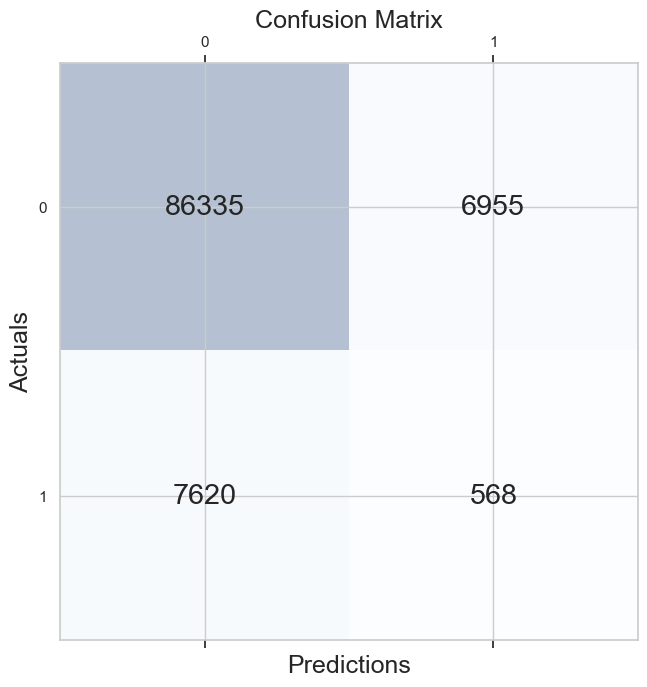

In [28]:
with mlflow.start_run(experiment_id=835998010215156356):
    
    hyperparameters = {
        'C': np.logspace(-3, 1, 10)
    }
    # Define the model
    svc = LinearSVC(random_state=1, class_weight='balanced')
    #creation of the custom scorer from the function
    custom_scorer = make_scorer(my_score)  
    # Define GridSearchCV object
    start_time = time.time()
    
    grid_search = model_selection.RandomizedSearchCV(
            svc,
            hyperparameters,
            cv=5,
            n_iter = 10,
            scoring=custom_scorer,#here we use our custom scorer as our scoring function
            n_jobs = -1,
            verbose=0)

    # Fit model
    best_clf = grid_search.fit(X_train_sampled_smaller, y_train_sampled_smaller)
    end_time = time.time()
    execution_time = end_time - start_time

    svc = LinearSVC(**best_clf.best_params_,
                   random_state=1,
                   class_weight='balanced', )

    #we used a sampled version to be faster in the gridsearch, but let's use all the train set in the final fit
    svc.fit(X_train,y_train)
    predicted = svc.predict(X_test)
    mlflow.log_metric("execution_time", execution_time)
    print("execution_time", execution_time)
    mlflow.log_params(svc.get_params())
    my_conf_mat = plot_model_confusion_matrix(svc)
    mlflow.log_figure(my_conf_mat, "confusion_matrix.png")

    signature = infer_signature(X_test, predicted)
    mlflow.sklearn.log_model(
        svc, "model", registered_model_name="svc", signature=signature
    )

Now let's go to a lightGBM model, and compare the results

In [30]:
display(resultize(grid_search).loc[resultize(grid_search)['rank_test_score']==1])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,128.060032,0.185910,0.339984,0.109669,0.001,{'C': 0.001},0.532496,0.426553,0.415483,0.486018,0.216882,0.415486,0.107919,1
1,120.909676,8.600297,0.381359,0.075840,0.002783,{'C': 0.0027825594022071257},0.532496,0.426553,0.415483,0.486018,0.216882,0.415486,0.107919,1
2,110.188237,0.344255,0.349174,0.039414,0.007743,{'C': 0.007742636826811269},0.532496,0.426553,0.415483,0.486018,0.216882,0.415486,0.107919,1
3,117.434776,3.505611,0.397048,0.065040,0.021544,{'C': 0.021544346900318832},0.532496,0.426553,0.415483,0.486018,0.216882,0.415486,0.107919,1
4,119.322178,1.571072,0.553211,0.313565,0.059948,{'C': 0.05994842503189409},0.532496,0.426553,0.415483,0.486018,0.216882,0.415486,0.107919,1
5,121.400544,0.206135,0.710748,0.364327,0.16681,{'C': 0.1668100537200059},0.532496,0.426553,0.415483,0.486018,0.216882,0.415486,0.107919,1
6,124.208212,3.726111,0.666621,0.551397,0.464159,{'C': 0.46415888336127775},0.532496,0.426553,0.415483,0.486018,0.216882,0.415486,0.107919,1
7,126.956599,1.180794,0.899031,0.374040,1.29155,{'C': 1.2915496650148828},0.532496,0.426553,0.415483,0.486018,0.216882,0.415486,0.107919,1
8,115.437901,1.706203,0.389257,0.066101,3.593814,{'C': 3.593813663804626},0.532496,0.426553,0.415483,0.486018,0.216882,0.415486,0.107919,1
9,96.212657,22.906779,0.234485,0.132331,10.0,{'C': 10.0},0.532496,0.426553,0.415483,0.486018,0.216882,0.415486,0.107919,1


For the first lightGBM test, we start without SMOTE, and just using the class balancing

/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be remov

/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be remov

/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


acc 0.740948777074834
execution_time 2890.9798600673676
custom_score 0.6008086425672005
auc 0.7852919085068266


Registered model 'LightGBM' already exists. Creating a new version of this model...
2023/10/06 16:39:50 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: LightGBM, version 6
Created version '6' of model 'LightGBM'.


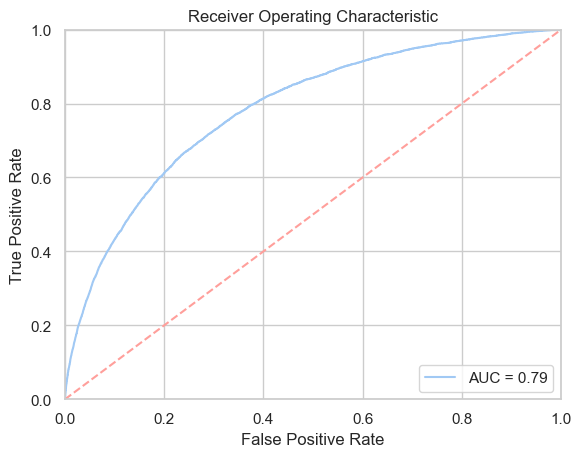

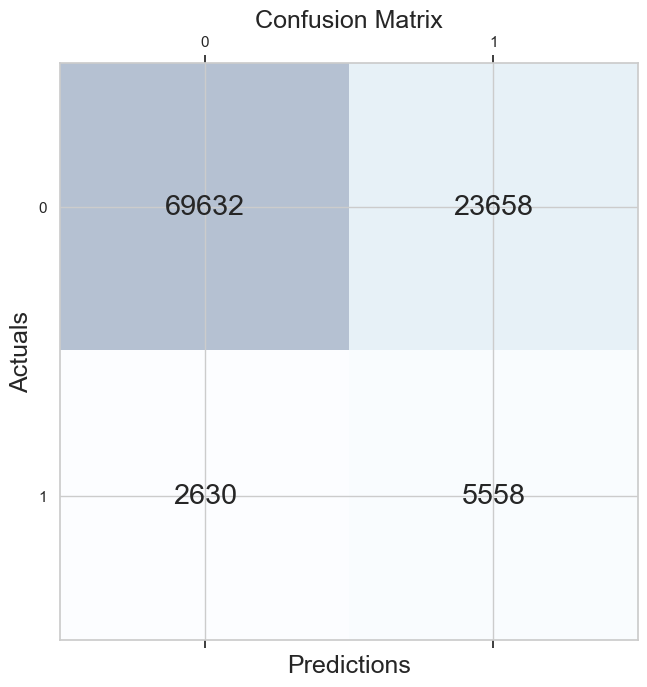

In [32]:
with mlflow.start_run(experiment_id=835998010215156356):
    
    hyperparameters = {
        'n_estimators': [2000, 4000, 5000, 7000, 10000],
        'learning_rate': [0.01, 0.02, 0.1, 1],
        'num_leaves':[10, 30, 50, 80],
        'max_depth':[8, 10, 20, 40],
    }
    # Define logistic regression model
    model = LGBMClassifier(random_state=1, 
                           class_weight='balanced', 
                           reg_alpha=0.041545473,
                           reg_lambda=0.0735294,
                           min_split_gain=0.0222415,
                           colsample_bytree=0.9497036,
                           subsample=0.8715623,
                           min_child_weight=39.3259775,
                           silent=-1,
                           verbose=-1,)
    custom_scorer = make_scorer(my_score)
    grid_search = model_selection.RandomizedSearchCV(
            model,
            hyperparameters,
            cv=5,
            n_iter = 10,
            scoring=custom_scorer,
            n_jobs = -1,
            verbose=0)
    
    
    start_time = time.time()
    best_clf = grid_search.fit(X_train_sampled_smaller, y_train_sampled_smaller)
    end_time = time.time()
    execution_time = end_time - start_time

    model = LGBMClassifier(**best_clf.best_params_,
                   random_state=1,
                   class_weight='balanced',
                   reg_alpha=0.041545473,
                   reg_lambda=0.0735294,
                   min_split_gain=0.0222415,
                   colsample_bytree=0.9497036,
                   subsample=0.8715623,
                   min_child_weight=39.3259775,
                   silent=-1,
                   verbose=-1, )

    #we used a sampled version to be faster in the gridsearch, but let's use all the train set in the final fit
    model.fit(X_train,y_train)
    predicted = model.predict(X_test)
    (acc, custom_score) = eval_metrics(y_test, predicted)
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    roc_auc = roc_auc_score(y_test, preds)
    mlflow.log_metric("acc", acc)
    mlflow.log_metric("execution_time", execution_time)
    mlflow.log_metric("custom_score", custom_score)
    mlflow.log_metric("auc", roc_auc)
    print("acc", acc)
    print("execution_time", execution_time)
    print("custom_score", custom_score)
    print("auc", roc_auc)
    roc_curve_model = plot_model_roc_curve(model, roc_auc)
    mlflow.log_figure(roc_curve_model, "roc_curve.png")
    mlflow.log_params(model.get_params())
    my_conf_mat = plot_model_confusion_matrix(model)
    mlflow.log_figure(my_conf_mat, "confusion_matrix.png")

    signature = infer_signature(X_test, predicted)
    mlflow.sklearn.log_model(
        model, "model", registered_model_name="LightGBM", signature=signature
    )

In [33]:
display(resultize(grid_search).loc[resultize(grid_search)['rank_test_score']==1])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_num_leaves,param_n_estimators,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,293.964884,2.147626,13.142067,0.577229,10,5000,10,0.01,"{'num_leaves': 10, 'n_estimators': 5000, 'max_...",0.604597,0.604355,0.606383,0.605223,0.598135,0.603739,0.002888,1


In [35]:
print(grid_search.best_params_)

{'num_leaves': 10, 'n_estimators': 5000, 'max_depth': 10, 'learning_rate': 0.01}


Now that we found a good result without SMOTE, let's try using it on our best performing algo to see if we can get better results

In [24]:
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X_smote, y_smote = pipeline.fit_resample(X_train, y_train)

In [25]:
X_smote.shape

(56817, 562)

In [26]:
X_test.shape

(101478, 562)

/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be remov

/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be remov

/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


acc 0.8434438991702635
execution_time 2153.1528890132904
custom_score 0.6038421379388192
auc 0.7702284789596902


Registered model 'LightGBM' already exists. Creating a new version of this model...
2023/10/07 09:58:32 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: LightGBM, version 8
Created version '8' of model 'LightGBM'.


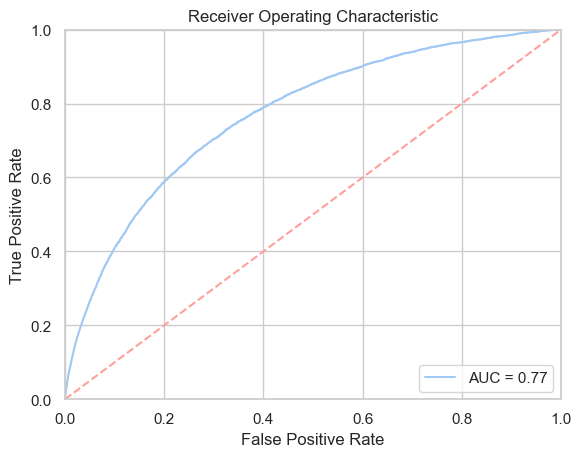

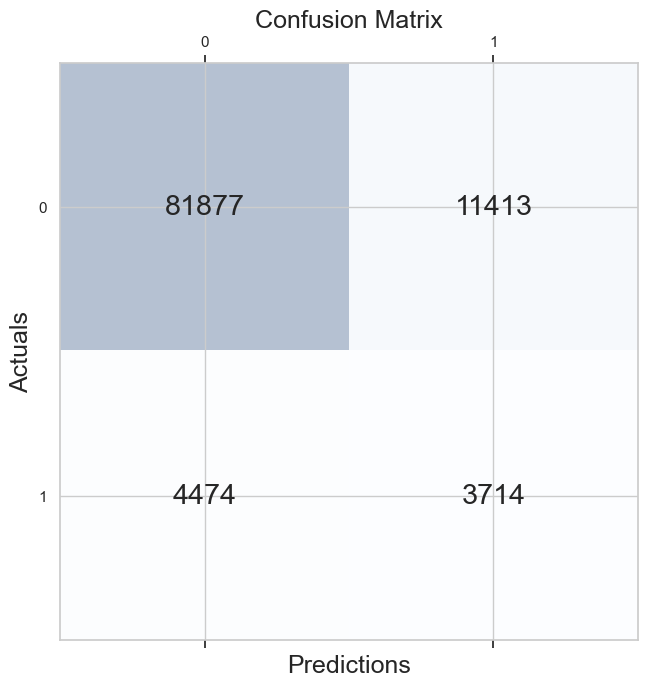

In [43]:
with mlflow.start_run(experiment_id=835998010215156356):
    
    hyperparameters = {
        'n_estimators': [2000, 4000, 5000, 7000, 10000],
        'learning_rate': [0.01, 0.02, 0.1, 1],
        'num_leaves':[10, 30, 50, 80],
        'max_depth':[8, 10, 20, 40],
    }
    # Define logistic regression model
    model = LGBMClassifier(random_state=1,
                           reg_alpha=0.041545473,
                           reg_lambda=0.0735294,
                           min_split_gain=0.0222415,
                           colsample_bytree=0.9497036,
                           subsample=0.8715623,
                           min_child_weight=39.3259775,
                           silent=-1,
                           verbose=-1,)
    custom_scorer = make_scorer(my_score)
    grid_search = model_selection.RandomizedSearchCV(
            model,
            hyperparameters,
            cv=5,
            n_iter = 10,
            scoring=custom_scorer,
            n_jobs = -1,
            verbose=0)
    
    
    start_time = time.time()
    best_clf = grid_search.fit(X_smote, y_smote)
    end_time = time.time()
    execution_time = end_time - start_time

    model = LGBMClassifier(**best_clf.best_params_,
                   random_state=1,
                   reg_alpha=0.041545473,
                   reg_lambda=0.0735294,
                   min_split_gain=0.0222415,
                   colsample_bytree=0.9497036,
                   subsample=0.8715623,
                   min_child_weight=39.3259775,
                   silent=-1,
                   verbose=-1, )

    #we used a sampled version to be faster in the gridsearch, but let's use all the train set in the final fit
    model.fit(X_smote,y_smote)
    predicted = model.predict(X_test)
    (acc, custom_score) = eval_metrics(y_test, predicted)
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    roc_auc = roc_auc_score(y_test, preds)
    mlflow.log_metric("acc", acc)
    mlflow.log_metric("execution_time", execution_time)
    mlflow.log_metric("custom_score", custom_score)
    mlflow.log_metric("auc", roc_auc)
    print("acc", acc)
    print("execution_time", execution_time)
    print("custom_score", custom_score)
    print("auc", roc_auc)
    roc_curve_model = plot_model_roc_curve(model, roc_auc)
    mlflow.log_figure(roc_curve_model, "roc_curve.png")
    mlflow.log_params(model.get_params())
    my_conf_mat = plot_model_confusion_matrix(model)
    mlflow.log_figure(my_conf_mat, "confusion_matrix.png")

    signature = infer_signature(X_test, predicted)
    mlflow.sklearn.log_model(
        model, "model", registered_model_name="LightGBM", signature=signature
    )

The best model gives an auc of 0.77, which is close to our model without using SMOTE, but not as good. So let's focus on the model with just the balanced classes

In [44]:
display(resultize(grid_search).loc[resultize(grid_search)['rank_test_score']==1])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_num_leaves,param_n_estimators,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,287.841011,9.836908,14.298484,0.959798,80,4000,40,0.1,"{'num_leaves': 80, 'n_estimators': 4000, 'max_...",0.273417,0.273354,0.274885,0.274734,0.374101,0.294098,0.040006,1


In [45]:
print(grid_search.best_params_)

{'num_leaves': 80, 'n_estimators': 4000, 'max_depth': 40, 'learning_rate': 0.1}


Now, we can try to focus again on the model that gave us the best results, the LGBM with balanced classes, so we can try to go more into details with the hyperparameters to use

/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be remov

/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be remov

/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/maxence/anaconda3/envs/test/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


acc 0.7475511933621081
execution_time 1857.6605577468872
custom_score 0.6030398422843334
auc 0.7856336524203462


Registered model 'LightGBM' already exists. Creating a new version of this model...
2023/10/07 10:45:39 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: LightGBM, version 9
Created version '9' of model 'LightGBM'.


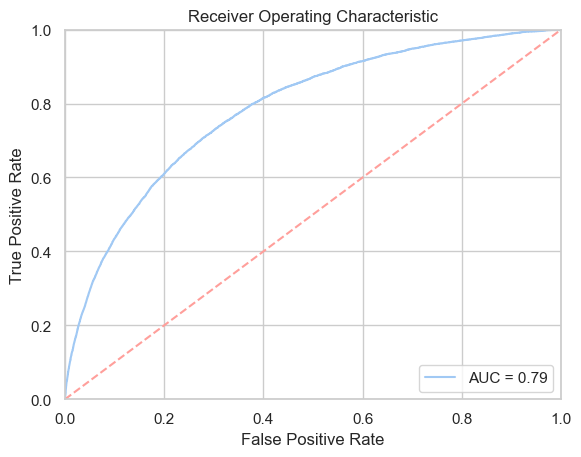

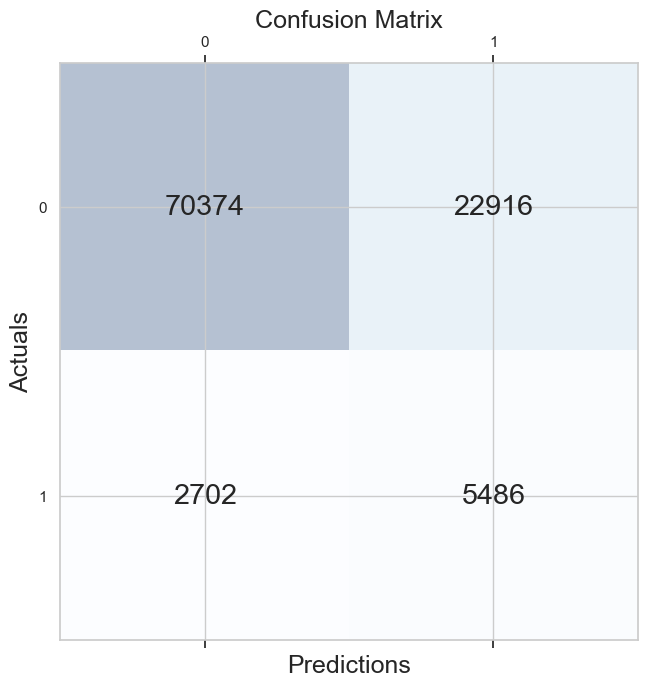

In [46]:
with mlflow.start_run(experiment_id=835998010215156356):
    
     
    hyperparameters = {
        'n_estimators': [4500, 5000, 5500],
        'learning_rate': [0.005, 0.01, 0.15],
        'num_leaves':[8, 9, 10, 11],
        'max_depth':[9, 10, 11, 12],
    }
    # Define logistic regression model
    model = LGBMClassifier(random_state=1, 
                           class_weight='balanced', 
                           reg_alpha=0.041545473,
                           reg_lambda=0.0735294,
                           min_split_gain=0.0222415,
                           colsample_bytree=0.9497036,
                           subsample=0.8715623,
                           min_child_weight=39.3259775,
                           silent=-1,
                           verbose=-1,)
    custom_scorer = make_scorer(my_score)
    grid_search = model_selection.RandomizedSearchCV(
            model,
            hyperparameters,
            cv=5,
            n_iter = 10,
            scoring=custom_scorer,
            n_jobs = -1,
            verbose=0)
    
    
    start_time = time.time()
    best_clf = grid_search.fit(X_train_sampled_smaller, y_train_sampled_smaller)
    end_time = time.time()
    execution_time = end_time - start_time

    model = LGBMClassifier(**best_clf.best_params_,
                   random_state=1,
                   class_weight='balanced',
                   reg_alpha=0.041545473,
                   reg_lambda=0.0735294,
                   min_split_gain=0.0222415,
                   colsample_bytree=0.9497036,
                   subsample=0.8715623,
                   min_child_weight=39.3259775,
                   silent=-1,
                   verbose=-1, )

    #we used a sampled version to be faster in the gridsearch, but let's use all the train set in the final fit
    model.fit(X_train,y_train)
    predicted = model.predict(X_test)
    (acc, custom_score) = eval_metrics(y_test, predicted)
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    roc_auc = roc_auc_score(y_test, preds)
    mlflow.log_metric("acc", acc)
    mlflow.log_metric("execution_time", execution_time)
    mlflow.log_metric("custom_score", custom_score)
    mlflow.log_metric("auc", roc_auc)
    print("acc", acc)
    print("execution_time", execution_time)
    print("custom_score", custom_score)
    print("auc", roc_auc)
    roc_curve_model = plot_model_roc_curve(model, roc_auc)
    mlflow.log_figure(roc_curve_model, "roc_curve.png")
    mlflow.log_params(model.get_params())
    my_conf_mat = plot_model_confusion_matrix(model)
    mlflow.log_figure(my_conf_mat, "confusion_matrix.png")

    signature = infer_signature(X_test, predicted)
    mlflow.sklearn.log_model(
        model, "model", registered_model_name="LightGBM", signature=signature
    )

we are still around the same value for the roc_auc

In [47]:
display(resultize(grid_search).loc[resultize(grid_search)['rank_test_score']==1])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_num_leaves,param_n_estimators,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,294.408681,1.693517,11.080461,0.420319,11,5500,10,0.01,"{'num_leaves': 11, 'n_estimators': 5500, 'max_...",0.607098,0.606146,0.60558,0.605388,0.600682,0.604979,0.002229,1


In [48]:
print(grid_search.best_params_)

{'num_leaves': 11, 'n_estimators': 5500, 'max_depth': 10, 'learning_rate': 0.01}


In [28]:
X_train_sampled_02=X_train.sample(frac=0.2,random_state=1)
y_train_sampled_02= y_train[X_train_sampled_02.index]
print(X_train_sampled_02.shape)

(41206, 562)


In [32]:
with mlflow.start_run(experiment_id=835998010215156356):
    
    hyperparameters = {
        'gamma': np.logspace(-3, 1, 10)
    }
    # Define the model
    classifier = svm.SVC(kernel='rbf', class_weight='balanced', random_state=1)
    #creation of the custom scorer from the function
    custom_scorer = make_scorer(my_score)  
    # Define GridSearchCV object
    start_time = time.time()
    
    grid_search = model_selection.RandomizedSearchCV(
            classifier,
            hyperparameters,
            cv=5,
            n_iter = 10,
            scoring=custom_scorer,#here we use our custom scorer as our scoring function
            n_jobs = -1,
            verbose=0)

    # Fit model
    best_clf = grid_search.fit(X_train_sampled_02, y_train_sampled_02)
    end_time = time.time()
    execution_time = end_time - start_time

    classifier = svm.SVC(**best_clf.best_params_,
                   random_state=1,
                   class_weight='balanced')

    #we used a sampled version to be faster in the gridsearch, but let's use all the train set in the final fit
    classifier.fit(X_train,y_train)
    predicted = classifier.predict(X_test)
    mlflow.log_metric("execution_time", execution_time)
    print("execution_time", execution_time)
    mlflow.log_params(classifier.get_params())
    my_conf_mat = plot_model_confusion_matrix(classifier)
    mlflow.log_figure(my_conf_mat, "confusion_matrix.png")

    signature = infer_signature(X_test, predicted)
    mlflow.sklearn.log_model(
        classifier, "model", registered_model_name="random_forest", signature=signature
    )

KeyboardInterrupt: 

Now that we have the best model, let's check the optimal treshold to use in order to have the 10 times ration that we were looking for

In [33]:
X_train_with_valid, X_valid, y_train_with_valid, y_valid = train_test_split(
X_train, y_train, test_size=0.15, random_state=1)

[200]	training's auc: 0.961477	training's binary_logloss: 0.338228	valid_1's auc: 0.776548	valid_1's binary_logloss: 0.419997
acc 0.7584303987071089
custom_score 0.603440435307585
auc 0.7803430431069879


Registered model 'LightGBM' already exists. Creating a new version of this model...
2023/10/13 11:34:14 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: LightGBM, version 10
Created version '10' of model 'LightGBM'.


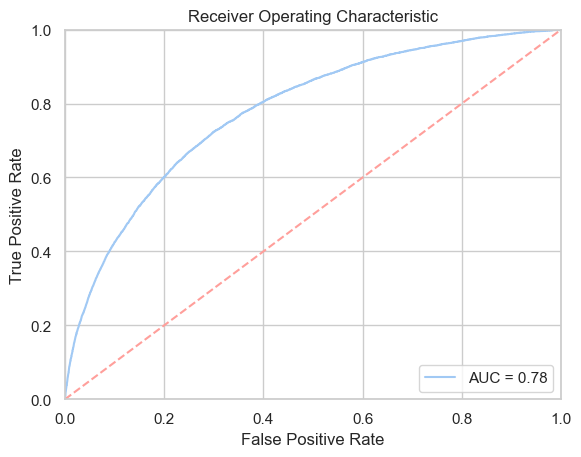

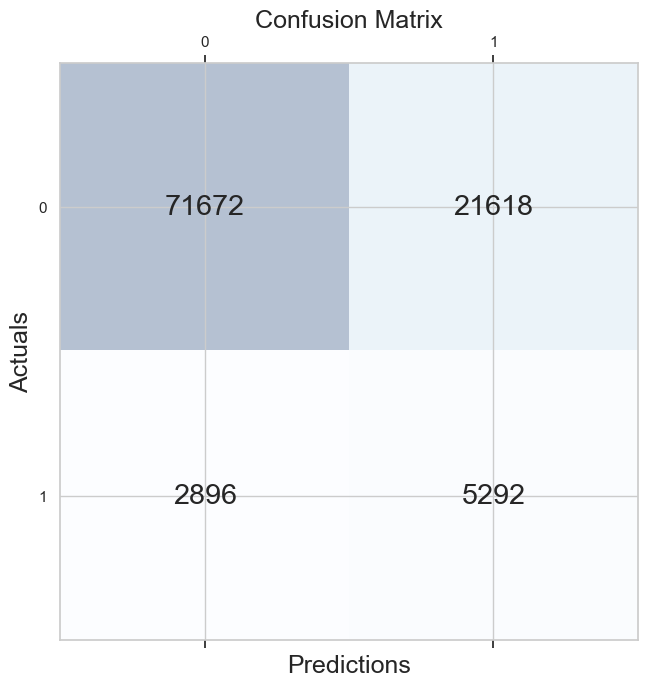

In [40]:
with mlflow.start_run(experiment_id=835998010215156356):
    clf = LGBMClassifier(num_leaves=80,
                           n_estimators= 4000,
                           max_depth=40,
                           learning_rate=0.1,
                           random_state=1,
                           class_weight='balanced',
                           reg_alpha=0.041545473,
                           reg_lambda=0.0735294,
                           min_split_gain=0.0222415,
                           colsample_bytree=0.9497036,
                           subsample=0.8715623,
                           min_child_weight=39.3259775,
                           silent=-1,
                           verbose=-1, )

        #we used a sampled version to be faster in the gridsearch, but let's use all the train set in the final fit
    clf.fit(X_train_with_valid, 
            y_train_with_valid, 
            eval_set=[(X_train_with_valid, y_train_with_valid), (X_valid, y_valid)],
            eval_metric= 'auc', 
            verbose= 200, 
            early_stopping_rounds= 200)
    predicted = clf.predict(X_test)
    (acc, custom_score) = eval_metrics(y_test, predicted)
    probs = clf.predict_proba(X_test)
    preds = probs[:,1]
    roc_auc = roc_auc_score(y_test, preds)
    mlflow.log_metric("acc", acc)
    mlflow.log_metric("custom_score", custom_score)
    mlflow.log_metric("auc", roc_auc)
    print("acc", acc)
    print("custom_score", custom_score)
    print("auc", roc_auc)
    roc_curve_model = plot_model_roc_curve(clf, roc_auc)
    mlflow.log_figure(roc_curve_model, "roc_curve.png")
    mlflow.log_params(clf.get_params())
    my_conf_mat = plot_model_confusion_matrix(clf)
    mlflow.log_figure(my_conf_mat, "confusion_matrix.png")

    signature = infer_signature(X_test, predicted)
    mlflow.sklearn.log_model(
        clf, "model", registered_model_name="LightGBM", signature=signature
    )
    

Let's start with big steps between the different probabilities, to see the result we get:

In [42]:
print(probs)

[[0.22099387 0.77900613]
 [0.51291116 0.48708884]
 [0.92273818 0.07726182]
 ...
 [0.577796   0.422204  ]
 [0.72356197 0.27643803]
 [0.81698994 0.18301006]]


In [43]:
print(probs[:,0])

[0.22099387 0.51291116 0.92273818 ... 0.577796   0.72356197 0.81698994]


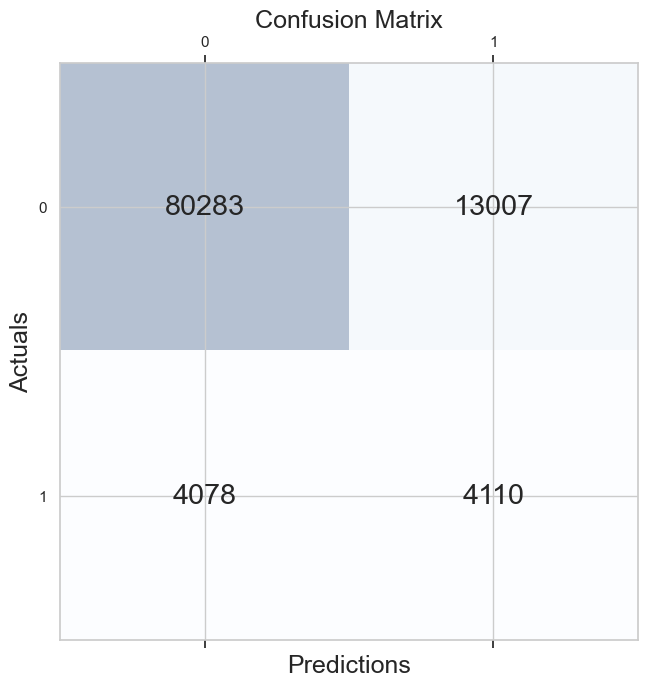

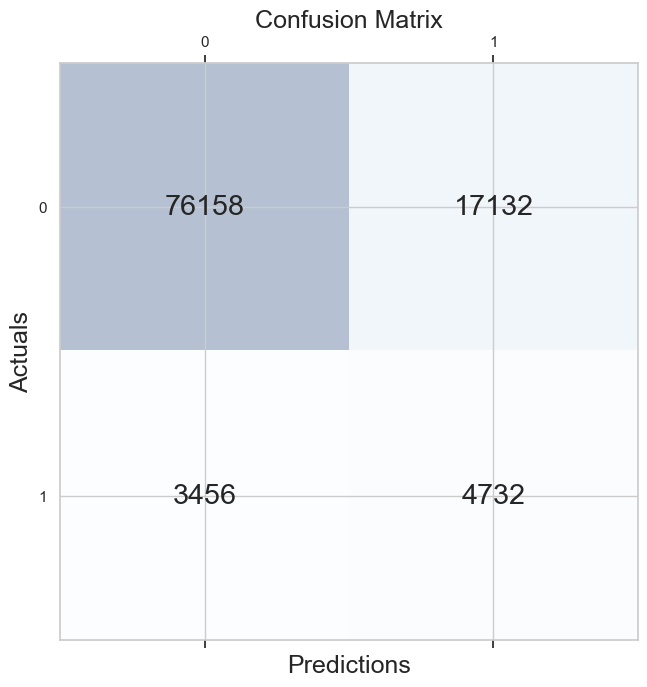

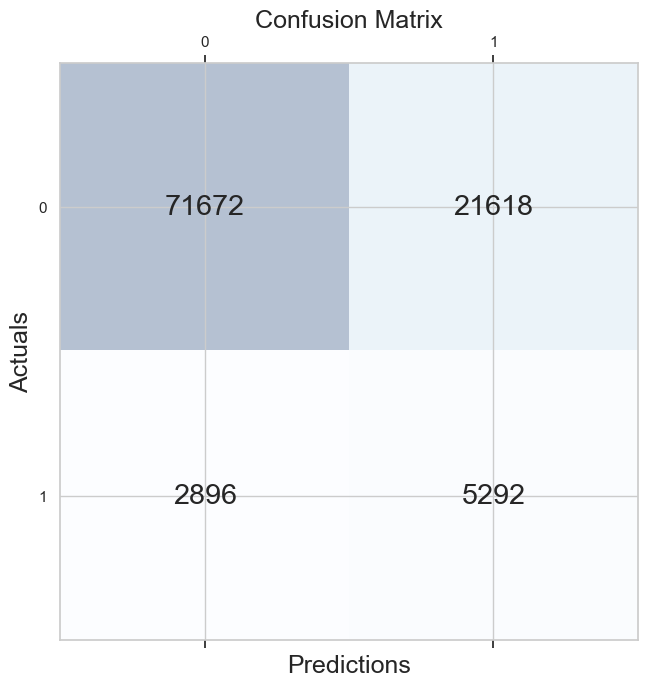

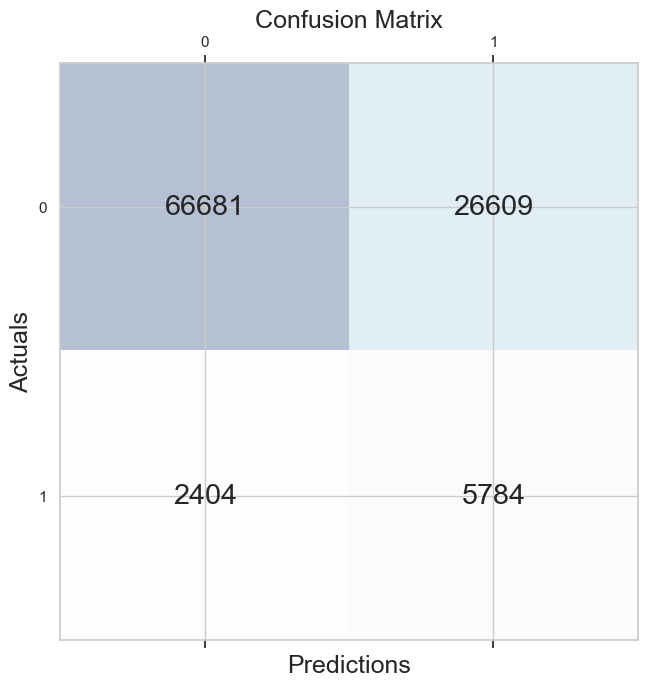

In [47]:
with mlflow.start_run(experiment_id=835998010215156356):

    k= 0.4
 
    while k< 0.6:
        predicted_with_tresh = predict_from_tresh(probs[:,0] ,k)
        (acc, custom_score) = eval_metrics(y_test, predicted_with_tresh)
        
        mlflow.log_metric("custom_score_k-" + str(k), custom_score)
        mlflow.log_metric("acc_k-" + str(k), acc)
        
        conf_matrix = confusion_matrix(y_true=y_test, y_pred=predicted_with_tresh)
        fig, ax = plt.subplots(figsize=(7.5, 7.5))
        ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
        for i in range(conf_matrix.shape[0]):
            for j in range(conf_matrix.shape[1]):
                ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

        plt.xlabel('Predictions', fontsize=18)
        plt.ylabel('Actuals', fontsize=18)
        plt.title('Confusion Matrix', fontsize=18)
        fig = plt.gcf()
        mlflow.log_figure(fig, "confusion_matrix_k-" + str(k) + ".png")
        k = k+0.05

What we see with those results is that it's with a score between 0.5 and 0.55 that we reach the 10 times ration, so let's get more into details to have a more accurate treshold

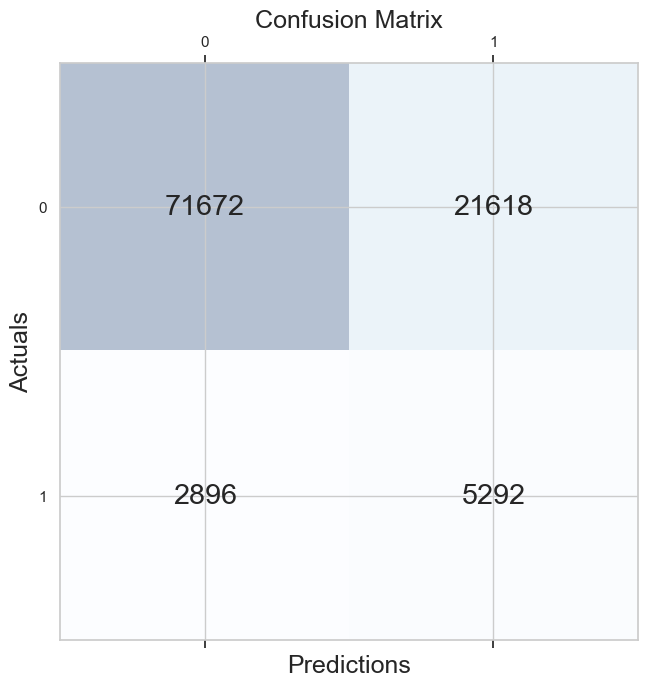

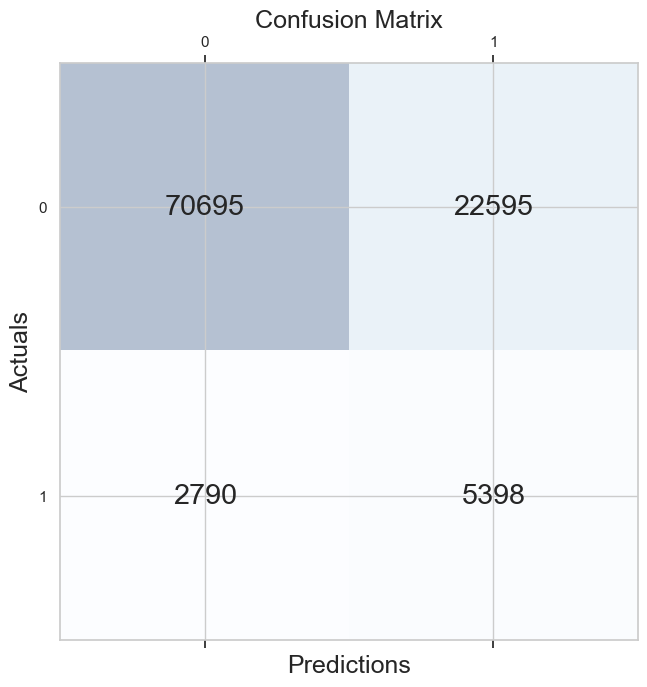

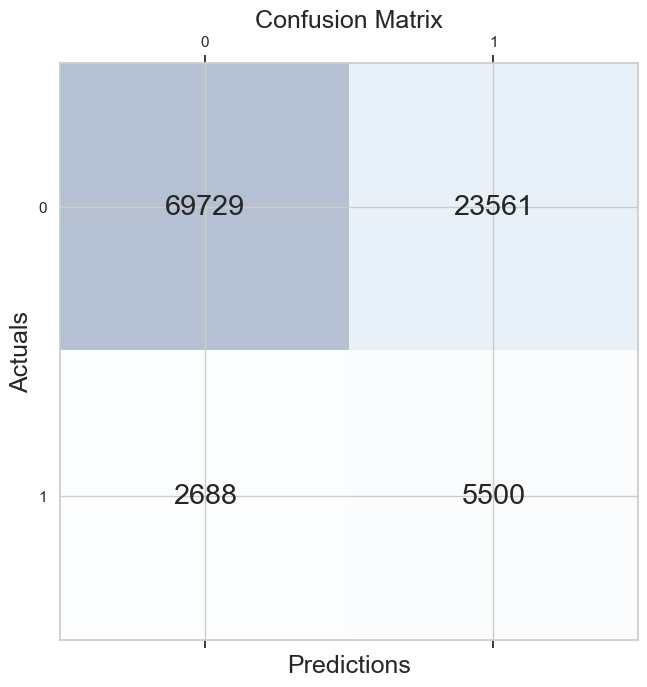

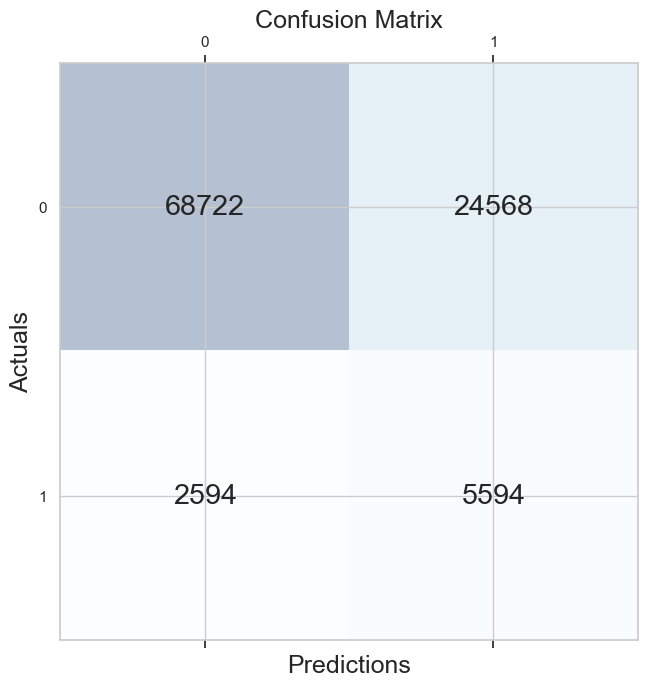

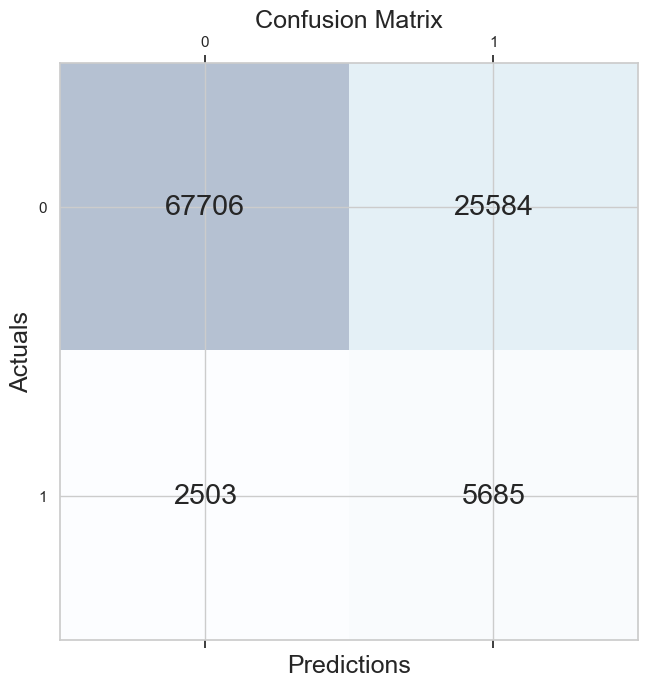

In [48]:
with mlflow.start_run(experiment_id=835998010215156356):

    k= 0.5
 
    while k< 0.55:
        predicted_with_tresh = predict_from_tresh(probs[:,0] ,k)
        (acc, custom_score) = eval_metrics(y_test, predicted_with_tresh)
        
        mlflow.log_metric("custom_score_k-" + str(k), custom_score)
        mlflow.log_metric("acc_k-" + str(k), acc)
        
        conf_matrix = confusion_matrix(y_true=y_test, y_pred=predicted_with_tresh)
        fig, ax = plt.subplots(figsize=(7.5, 7.5))
        ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
        for i in range(conf_matrix.shape[0]):
            for j in range(conf_matrix.shape[1]):
                ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

        plt.xlabel('Predictions', fontsize=18)
        plt.ylabel('Actuals', fontsize=18)
        plt.title('Confusion Matrix', fontsize=18)
        fig = plt.gcf()
        mlflow.log_figure(fig, "confusion_matrix_k-" + str(k) + ".png")
        k = k+0.01

as we can see here, we have the result we are looking for with a treshold of 0.54.

We can now go to the feature importance ofthe model:

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

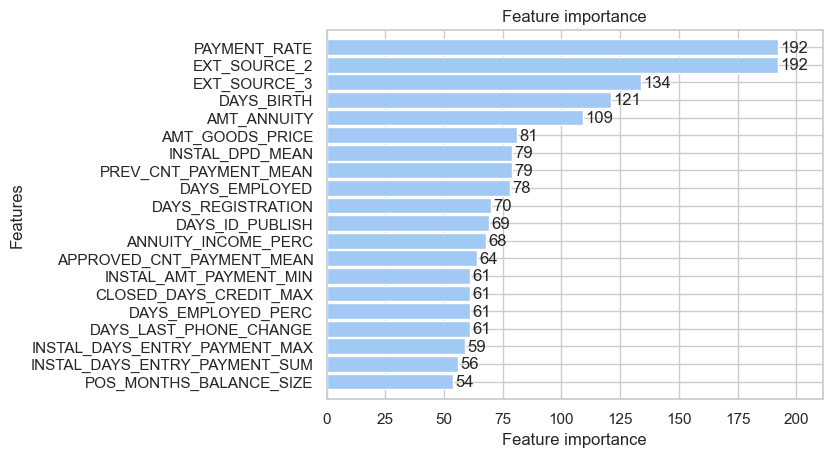

In [49]:
plot_importance(clf, height=0.9, max_num_features=20)

In [50]:
shap.initjs()

In [52]:
explainer = shap.TreeExplainer(clf, X_train, feature_names=X_train.columns.tolist())

In [53]:
shap_values_model_test = explainer.shap_values(X_test, check_additivity=False)

100%|===================| 101467/101478 [11:34<00:00]       

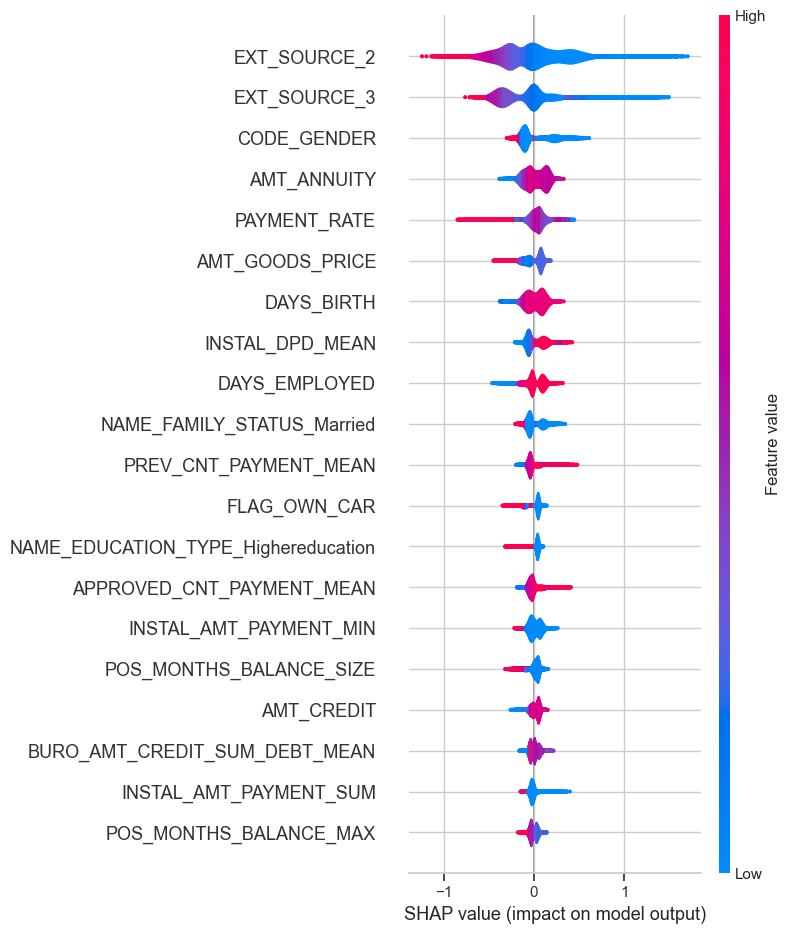

In [54]:
shap.summary_plot(shap_values_model_test, X_test, feature_names=X_train.columns.tolist(), plot_type='violin', show=False, max_display=20)

In [55]:
shap.force_plot(explainer.expected_value, shap_values_model_test[1], X_test.iloc[[1]])

In [56]:
shap.force_plot(explainer.expected_value, shap_values_model_test[5], X_test.iloc[[5]])

In [57]:
obj = sio.dump(clf, 'final_model_GBM.skops')

Now that all the rest is done, we can go through the data drif analysis of our model